<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis

from statsmodels.discrete.conditional_models import ConditionalLogit
from patsy import dmatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

In [83]:
def rclr(table):
    masked = ma.array(table.values, mask=table.values == 0)
    log = ma.log(masked)
    clr_data = log - log.mean(axis=1).reshape(-1, 1)
    clr_data = pd.DataFrame(clr_data, index=table.index, columns=table.columns).fillna(0)
    return clr_data

def clogit_predict(X, beta, groups):
    """ Assumes that groups is ordered. """
    cats = np.unique(groups)
    pred = []
    for c in cats:
        idx = [groups == c]
        X_ = X[idx]
        p = np.exp(X_[0] @ beta) / (np.exp(X_[0] @ beta) + np.exp(X_[1] @ beta)) 
        pred.append(p)
    return pd.Series(pred, index=cats)

def conditional_logistic_regression(table, metadata, matching, outcome, 
                                    train, test, **kwargs):
    X_train, md_train = table.loc[train], metadata.loc[train]
    X_test, md_test = table.loc[test], metadata.loc[test]
    y_train = (md_train[outcome] == 'ASD').astype(np.int64)
    # y_test = (md_test[outcome] == 'ASD').astype(np.int64)
    
    le = LabelEncoder()
    groups = le.fit_transform(md_train[matching].values)
    
    model = ConditionalLogit(endog=y_train, exog=X_train, groups=groups)
    res = model.fit_regularized(**kwargs)
    train_probs = clogit_predict(X_train.values, res.params, md_train[matching].values)
    test_probs = clogit_predict(X_test.values, res.params, md_test[matching].values)
    
    return train_probs, test_probs, res

In [139]:
# load biom tables
amp_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)
wgs_md = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)


amp_md = amp_md.sort_values(['Status', 'Match_IDs'])
wgs_md = wgs_md.sort_values(['Status', 'Match_IDs'])

amp_table = amp_table.loc[amp_md.index]
wgs_table = wgs_table.loc[wgs_md.index]

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load differentials
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v5.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)
wgs_stats = ranking(wgs_diffs, reference_percentile=50) 

sort_col = 'mean'

# collapse table by genus
cols = ['kingdom' ,'phylum', 'class', 'order', 'family', 'genus']
genus_lineage = mapping.apply(lambda x: ';'.join(map(str, x[cols])), axis=1)

amp_genera = pd.merge(amp_table.T, pd.DataFrame({'genus': genus_lineage}), 
                      left_index=True, right_index=True).groupby('genus').sum()

wgs_genera = pd.merge(wgs_table.T, pd.DataFrame({'genus': genus_lineage}), 
                      left_index=True, right_index=True).groupby('genus').sum()

# clr transform
amp_gclr = np.log(amp_genera + 1).T - np.log(amp_genera + 1).T.mean(axis=1).values.reshape(-1, 1)
wgs_gclr = np.log(wgs_genera + 1).T - np.log(wgs_genera + 1).T.mean(axis=1).values.reshape(-1, 1)

Perform data augmentation to boost the data size with Dirichilet bootstrapping

Perform Random forests classification on matchings

In [ ]:
def matching_diffs(table, md, matching, outcome, reference_outcome):
    """ Compute matched differentials. """
    table = pd.merge(md[[matching, outcome]], table, left_index=True, right_index=True)

    table = table.sort_values(by=[outcome, matching])

    case = table.loc[table[outcome] != reference_outcome]
    cont = table.loc[table[outcome] == reference_outcome]

    case_cont = pd.DataFrame(
        case.iloc[:, 2:].values - cont.iloc[:, 2:].values,
        index=case[matching], columns=case.columns[2:])
    return case_cont

def pseudo_negatives(table, md):
    """ Generate negative examples (i.e. control-control, asd-asd) 
        with dirichlet bootstrappinging"""

def matched_random_forests(matched_table, md):
    model = RandomForestClassifier()
    model.fit(matched_table)
    # TODO 

Perform conditional logistic regression classification for 16S with cross-validation

Berding2020
0.8023713812730708 0.9042253521126761 0.538395869300141 0.5454545454545454


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

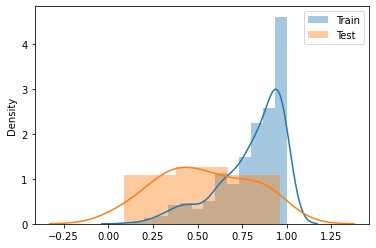

Chen2020
0.8192974230187943 0.9333333333333333 0.5100557666262305 0.5106382978723404


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

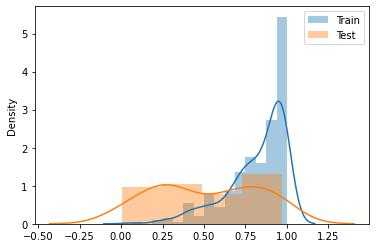

Dan2020
0.7743962390948701 0.9033613445378151 0.6041547904584674 0.6762589928057554


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

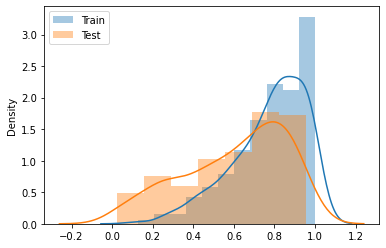

Fasano2020
0.814966356463243 0.9230769230769231 0.5277754614009174 0.48717948717948717


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

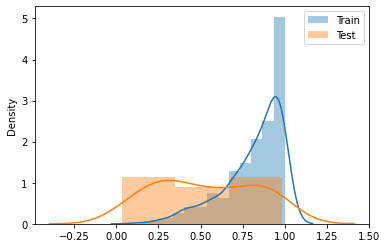

Fouquier2021
0.8228001616583017 0.9329446064139941 0.36403459563487184 0.3235294117647059


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

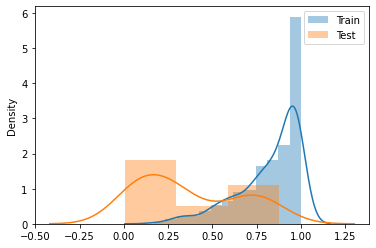

Kang2017
0.8134611719388246 0.9239766081871345 0.5166736103170748 0.6


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

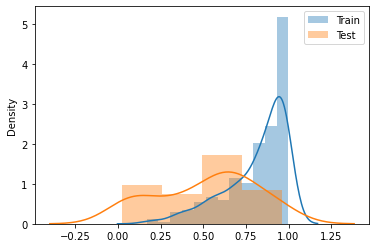

Zou2020


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.7855938250918285 0.9053254437869822 0.5148509531216227 0.5128205128205128


/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


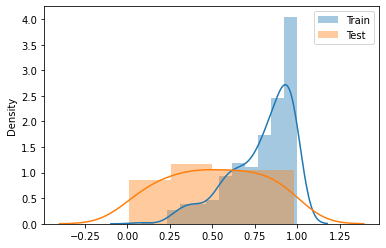

Zurita2019
0.7978660571458125 0.9154929577464789 0.5403854833438914 0.5909090909090909


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

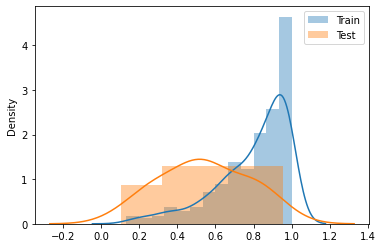

In [141]:
def run_clogit(c):
    train_idx = amp_md['Cohort'] != c
    test_idx = amp_md['Cohort'] == c
    train_p, test_p, summary = conditional_logistic_regression(
        amp_gclr, amp_md, 'Match_IDs', 'Status',
        train_idx, test_idx, alpha=0.01, L1_wt=1.0
    )
    return train_p, test_p, summary


cv_res = []
summaries = []
cohorts = amp_md['Cohort'].unique()
for c in cohorts:
    print(c)
    pp = run_clogit(c)
    train_p, test_p, res = pp
    print(train_p.mean(), np.mean(np.round(train_p)), test_p.mean(), np.mean(np.round(test_p)))
    
    sns.distplot(train_p, label='Train')
    sns.distplot(test_p, label='Test')
    plt.legend()
    plt.show()
    
    cv_res.append((c, train_p, test_p))
    summaries.append(res)

K-fold cross validation on matches

0.8107782547258929 0.9148936170212766 0.6244805794778 0.6666666666666666


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

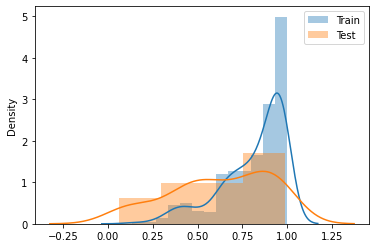

0.7963147132158855 0.9 0.6691003388099127 0.6808510638297872


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

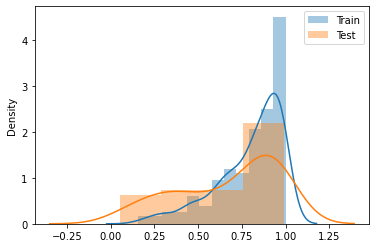

0.7771500389253302 0.9 0.8464830103091313 0.9148936170212766


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

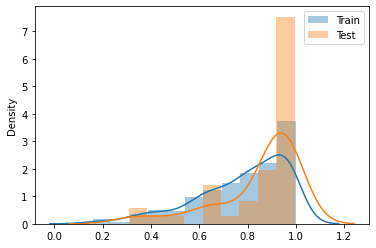

0.778913250565046 0.896969696969697 0.8221802262185158 0.8723404255319149


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

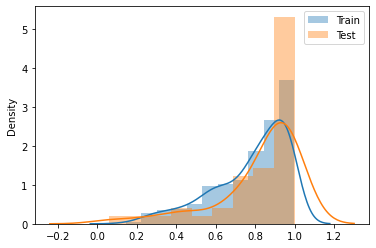

0.8042836821718556 0.9151515151515152 0.685776107443951 0.723404255319149


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

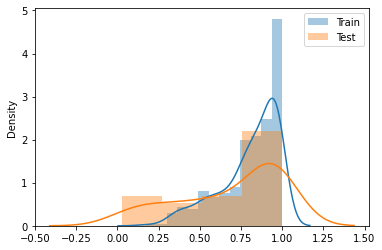

0.8273994175445241 0.9393939393939394 0.45997093603720574 0.425531914893617


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

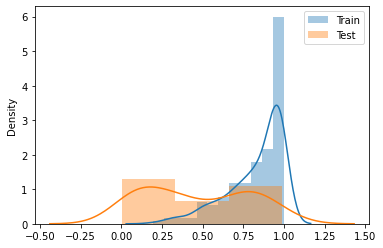

0.8099976797879859 0.9242424242424242 0.5877985396652048 0.6595744680851063


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

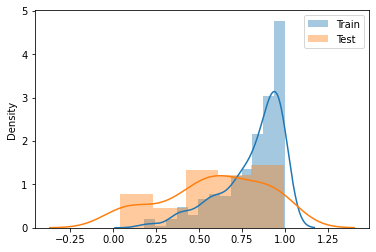

0.7947533015298096 0.906060606060606 0.6204499371485027 0.6382978723404256


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

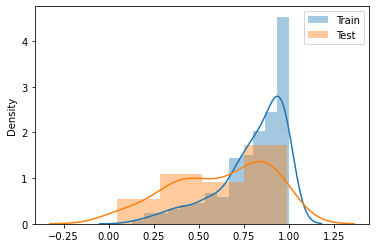

In [142]:
def run_clogit_split(train_m, test_m):
    """ Split by match pairs """
    train_idx = amp_md['Match_IDs'].apply(lambda x: x in train_m)
    test_idx = amp_md['Match_IDs'].apply(lambda x: x in test_m)
    train_p, test_p, summary = conditional_logistic_regression(
        amp_gclr, amp_md, 'Match_IDs', 'Status',
        train_idx, test_idx, alpha=0.01, L1_wt=1.0
    )
    return train_p, test_p, summary


cv_res = []
summaries = []
cohorts = amp_md['Cohort'].unique()
kf = KFold(n_splits=8)
matches = amp_md['Match_IDs'].unique()
for train_m, test_m in kf.split(matches):
    
    pp = run_clogit_split(matches[train_m], matches[test_m])
    train_p, test_p, res = pp
    print(train_p.mean(), np.mean(np.round(train_p)), test_p.mean(), np.mean(np.round(test_p)))
    
    sns.distplot(train_p, label='Train')
    sns.distplot(test_p, label='Test')
    plt.legend()
    plt.show()
    
    cv_res.append((c, train_p, test_p))
    summaries.append(res)

In [143]:
matching = 'Match_IDs'
outcome = 'Status'

y_train = (amp_md[outcome] == 'ASD').astype(np.int64).values.reshape(-1, 1)
le = LabelEncoder()
groups = le.fit_transform(amp_md[matching].values)
model = ConditionalLogit(endog=y_train, exog=amp_gclr, groups=groups)
res = model.fit_regularized(alpha=0.01, L1_wt=1)

train_probs = clogit_predict(amp_gclr.values, res.params, amp_md[matching].values)
print(train_probs.mean(), np.round(train_probs).mean())

0.7855650588603803 0.8992042440318302


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]


/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

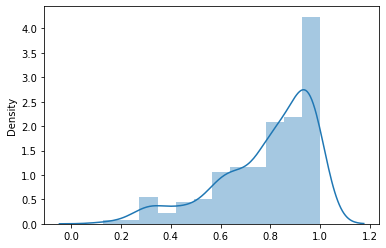

In [144]:
sns.distplot(train_probs)

In [145]:
train_idx = np.ones(len(amp_md)).astype(np.bool)
test_idx = np.ones(len(amp_md)).astype(np.bool)
train_p, test_p, summary = conditional_logistic_regression(
    amp_gclr, amp_md, 'Match_IDs', 'Status',
    train_idx, test_idx, alpha=0.01, L1_wt=1
)

<ipython-input-145-5fda3e08c748>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_idx = np.ones(len(amp_md)).astype(np.bool)
<ipython-input-145-5fda3e08c748>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_idx = np.ones(len(amp_md)).astype(np.bool)
<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidi

In [146]:
np.round(train_p).mean()

0.8992042440318302

Shotgun data

Averina2020
0.9787334757300746 1.0 0.45153428503694076 0.45454545454545453


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

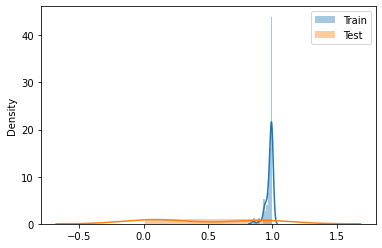

Dan2020
0.9732802572225647 1.0 0.523827008130826 0.5


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

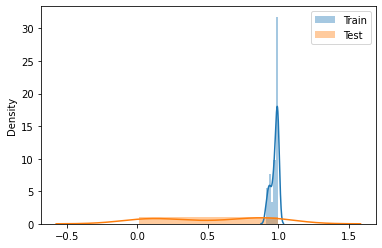

Wang2020
0.9696509087260208 1.0 0.47149999210916066 0.45161290322580644


<ipython-input-83-b0339f0a97d8>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_ = X[idx]
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

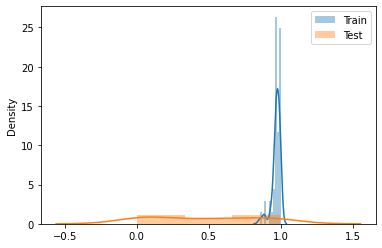

In [147]:
def run_clogit(c):
    train_idx = wgs_md['Cohort'] != c
    test_idx = wgs_md['Cohort'] == c
    train_p, test_p, summary = conditional_logistic_regression(
        wgs_gclr, wgs_md, 'Match_IDs', 'Status',
        train_idx, test_idx, alpha=0.01, L1_wt=1.0
    )
    return train_p, test_p, summary


cv_res = []
summaries = []
cohorts = wgs_md['Cohort'].unique()
for c in cohorts:
    print(c)
    pp = run_clogit(c)
    train_p, test_p, res = pp
    print(train_p.mean(), np.mean(np.round(train_p)), test_p.mean(), np.mean(np.round(test_p)))
    
    sns.distplot(train_p, label='Train')
    sns.distplot(test_p, label='Test')
    plt.legend()
    plt.show()
    
    cv_res.append((c, train_p, test_p))
    summaries.append(res)